In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder


In [46]:
# Load data
data = pd.read_csv('AirlineTweets.csv')
data = data[['airline_sentiment', 'text']].copy()

In [47]:
# Data overview
print(data.head())
print(data.info())

  airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB
None


C:\Users\Bolbol\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


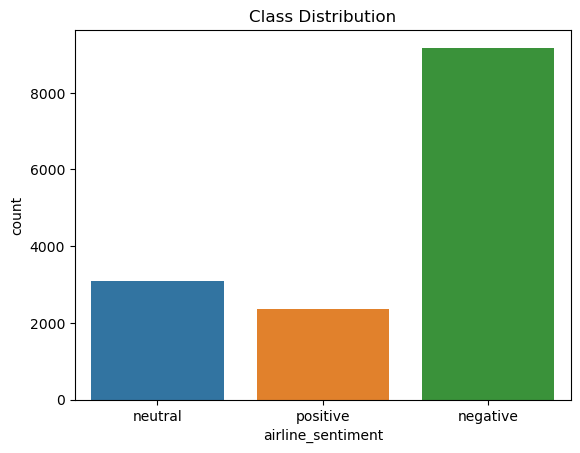

In [48]:
# Visualize class distribution
sns.countplot(data['airline_sentiment'])
plt.title('Class Distribution')
plt.show()


In [49]:
# Label encoding
label = LabelEncoder()
data['airline_sentiment'] = label.fit_transform(data['airline_sentiment'])


In [50]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [51]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(filtered_tokens)  # Join tokens back into a string

data['clean_text'] = data['text'].apply(preprocess_text)


In [52]:
# TF-IDF Vectorization (with feature limit)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.9)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['clean_text'])

X = tfidf_matrix
y = data['airline_sentiment']


In [53]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [54]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [55]:
# Logistic regression with cross-validation for hyperparameter tuning
param_grid = {'C': [0.1, 1, 10]}
log_reg = LogisticRegression(max_iter=500)
clf = GridSearchCV(log_reg, param_grid, cv=5)
clf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.1, 1, 10]})

In [56]:
# Best model performance
print("Best Hyperparameter (C):", clf.best_params_)
print("Train acc:", clf.score(X_train, y_train))
print("Test acc:", clf.score(X_test, y_test))


Best Hyperparameter (C): {'C': 10}
Train acc: 0.9442956371725609
Test acc: 0.8708915925186127


In [57]:
# Train and Test AUC scores
Pr_train = clf.predict_proba(X_train)
Pr_test = clf.predict_proba(X_test)
print("Train AUC:", roc_auc_score(y_train, Pr_train, multi_class='ovo'))
print("Test AUC:", roc_auc_score(y_test, Pr_test, multi_class='ovo'))


Train AUC: 0.9892579527016947
Test AUC: 0.962608813887143


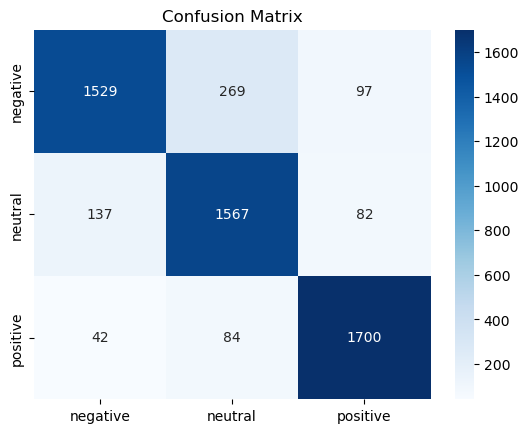

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.81      0.85      1895
     neutral       0.82      0.88      0.85      1786
    positive       0.90      0.93      0.92      1826

    accuracy                           0.87      5507
   macro avg       0.87      0.87      0.87      5507
weighted avg       0.87      0.87      0.87      5507



In [58]:
# Confusion Matrix and Classification Report
P_train = clf.predict(X_train)
P_test = clf.predict(X_test)
cm = confusion_matrix(y_test, P_test)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label.classes_, yticklabels=label.classes_)
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_test, P_test, target_names=label.classes_))


In [59]:
# Display top positive/negative words with weights
word_index_map = tfidf_vectorizer.vocabulary_
coef = clf.best_estimator_.coef_[0]  

In [61]:
word_weights = pd.DataFrame({'word': list(word_index_map.keys()), 'weight': coef[list(word_index_map.values())]})
word_weights_sorted = word_weights.sort_values(by='weight', ascending=False)

if label.classes_[1] == 'positive':  # Assuming 'positive' is encoded as 1
    positive_words = word_weights_sorted[word_weights_sorted['weight'] > threshold]
    negative_words = word_weights_sorted[word_weights_sorted['weight'] < -threshold]
else:  # If 'negative' is encoded as 1, we need to flip the interpretation
    positive_words = word_weights_sorted[word_weights_sorted['weight'] < -threshold]
    negative_words = word_weights_sorted[word_weights_sorted['weight'] > threshold]

# Display most positive and negative words
print("Most positive words:")
print(positive_words.head(10))

print("Most negative words:")
print(negative_words.head(10))

Most positive words:
            word    weight
3119  difficulty -2.000325
2842   guideline -2.000620
2151    coworker -2.000884
4017     opposed -2.006780
2147      beauty -2.007625
1905          kp -2.010249
4400      nassau -2.017650
845     frequent -2.023017
2905  tremendous -2.025152
2336         grr -2.029440
Most negative words:
              word    weight
695          worst  7.773798
56            hour  7.103070
421   disappointed  6.118791
170             hr  5.889474
1300    ridiculous  5.409274
102        nothing  5.235535
171           fail  5.129212
583           paid  5.109107
2725          hire  4.916903
1402         third  4.891158
